# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6211023161986997 -3.109387043490154
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [109]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [110]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [111]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [112]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [113]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [114]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [115]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [116]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs) # GAN using success rate
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:]) # Q-learning using max future rewards
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)# Policy gradient for state and action mapping
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [117]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [118]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [119]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [120]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [121]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [122]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode:0 meanR:10.0000 rate:0.0200 gloss:0.1288 dloss:1.4655 dlossR:0.7781 dlossQ:0.6874
Episode:1 meanR:9.5000 rate:0.0180 gloss:0.0553 dloss:1.4176 dlossR:0.7255 dlossQ:0.6921
Episode:2 meanR:9.3333 rate:0.0180 gloss:0.0013 dloss:1.3784 dlossR:0.6852 dlossQ:0.6932
Episode:3 meanR:9.5000 rate:0.0200 gloss:-0.0592 dloss:1.3281 dlossR:0.6366 dlossQ:0.6915
Episode:4 meanR:9.8000 rate:0.0220 gloss:-0.1225 dloss:1.2706 dlossR:0.5854 dlossQ:0.6852
Episode:5 meanR:9.8333 rate:0.0200 gloss:-0.1768 dloss:1.2286 dlossR:0.5510 dlossQ:0.6776
Episode:6 meanR:9.8571 rate:0.0200 gloss:-0.2284 dloss:1.1917 dlossR:0.5228 dlossQ:0.6689
Episode:7 meanR:9.8750 rate:0.0200 gloss:-0.2834 dloss:1.1578 dlossR:0.4986 dlossQ:0.6592
Episode:8 meanR:9.7778 rate:0.0180 gloss:-0.3447 dloss:1.1266 dlossR:0.4771 dlossQ:0.6495
Episode:9 meanR:9.7000 rate:0.0180 gloss:-0.4204 dloss:1.0838 dlossR:0.4490 dlossQ:0.6348
Episode:10 meanR:16.8182 rate:0.1760 gloss:-0.0341 dloss:1.3243 dlossR:0.6271 dlossQ:0.6973
Episode:11

Episode:93 meanR:34.7021 rate:0.0860 gloss:-1.4848 dloss:0.6365 dlossR:0.2971 dlossQ:0.3393
Episode:94 meanR:34.8526 rate:0.0980 gloss:-1.4659 dloss:0.6706 dlossR:0.3250 dlossQ:0.3457
Episode:95 meanR:35.0625 rate:0.1100 gloss:-1.4319 dloss:0.7091 dlossR:0.3522 dlossQ:0.3569
Episode:96 meanR:35.4742 rate:0.1500 gloss:-1.4558 dloss:0.7901 dlossR:0.4422 dlossQ:0.3479
Episode:97 meanR:35.8980 rate:0.1540 gloss:-1.4293 dloss:0.8080 dlossR:0.4509 dlossQ:0.3571
Episode:98 meanR:36.1010 rate:0.1120 gloss:-1.4994 dloss:0.6907 dlossR:0.3556 dlossQ:0.3352
Episode:99 meanR:36.5400 rate:0.1600 gloss:-1.5551 dloss:0.8024 dlossR:0.4791 dlossQ:0.3233
Episode:100 meanR:37.1300 rate:0.1380 gloss:-1.5553 dloss:0.7425 dlossR:0.4217 dlossQ:0.3209
Episode:101 meanR:37.4600 rate:0.0840 gloss:-1.6244 dloss:0.5968 dlossR:0.2939 dlossQ:0.3029
Episode:102 meanR:37.6900 rate:0.0640 gloss:-1.8083 dloss:0.5130 dlossR:0.2494 dlossQ:0.2636
Episode:103 meanR:37.7300 rate:0.0280 gloss:-1.6535 dloss:0.4553 dlossR:0.159

Episode:186 meanR:37.1600 rate:0.0800 gloss:-1.6017 dloss:0.5862 dlossR:0.2806 dlossQ:0.3056
Episode:187 meanR:36.4700 rate:0.0640 gloss:-1.6099 dloss:0.5434 dlossR:0.2414 dlossQ:0.3020
Episode:188 meanR:36.2900 rate:0.1220 gloss:-1.5285 dloss:0.7061 dlossR:0.3797 dlossQ:0.3264
Episode:189 meanR:35.4500 rate:0.0900 gloss:-1.6269 dloss:0.6051 dlossR:0.3058 dlossQ:0.2993
Episode:190 meanR:35.4000 rate:0.1160 gloss:-1.6352 dloss:0.6693 dlossR:0.3716 dlossQ:0.2976
Episode:191 meanR:35.0800 rate:0.1060 gloss:-1.6506 dloss:0.6402 dlossR:0.3468 dlossQ:0.2934
Episode:192 meanR:35.1000 rate:0.1160 gloss:-1.5854 dloss:0.6776 dlossR:0.3678 dlossQ:0.3098
Episode:193 meanR:35.3400 rate:0.1340 gloss:-1.7303 dloss:0.7032 dlossR:0.4287 dlossQ:0.2745
Episode:194 meanR:35.3700 rate:0.1040 gloss:-1.7473 dloss:0.6242 dlossR:0.3502 dlossQ:0.2741
Episode:195 meanR:35.0400 rate:0.0440 gloss:-1.5073 dloss:0.5324 dlossR:0.2011 dlossQ:0.3313
Episode:196 meanR:34.5000 rate:0.0420 gloss:-1.5130 dloss:0.5262 dloss

Episode:280 meanR:39.9500 rate:0.0240 gloss:-2.2000 dloss:0.3019 dlossR:0.1239 dlossQ:0.1781
Episode:281 meanR:39.9900 rate:0.0540 gloss:-1.8119 dloss:0.4762 dlossR:0.2173 dlossQ:0.2589
Episode:282 meanR:39.9500 rate:0.0720 gloss:-1.7425 dloss:0.5458 dlossR:0.2664 dlossQ:0.2793
Episode:283 meanR:39.9500 rate:0.1020 gloss:-1.6881 dloss:0.6241 dlossR:0.3386 dlossQ:0.2855
Episode:284 meanR:40.2700 rate:0.1460 gloss:-1.7278 dloss:0.7329 dlossR:0.4590 dlossQ:0.2738
Episode:285 meanR:40.9700 rate:0.2540 gloss:-1.5636 dloss:1.0435 dlossR:0.7238 dlossQ:0.3198
Episode:286 meanR:41.6300 rate:0.2120 gloss:-1.5606 dloss:0.9331 dlossR:0.6110 dlossQ:0.3221
Episode:287 meanR:42.8200 rate:0.3020 gloss:-1.3702 dloss:1.1757 dlossR:0.7951 dlossQ:0.3807
Episode:288 meanR:42.8800 rate:0.1340 gloss:-1.6073 dloss:0.7241 dlossR:0.4163 dlossQ:0.3078
Episode:289 meanR:43.8000 rate:0.2740 gloss:-1.3333 dloss:1.1070 dlossR:0.7161 dlossQ:0.3908
Episode:290 meanR:43.3200 rate:0.0200 gloss:-1.7916 dloss:0.3896 dloss

Episode:370 meanR:56.6000 rate:0.0600 gloss:-1.3829 dloss:0.6156 dlossR:0.2452 dlossQ:0.3704
Episode:371 meanR:56.5100 rate:0.0320 gloss:-1.5123 dloss:0.5076 dlossR:0.1754 dlossQ:0.3322
Episode:372 meanR:56.4700 rate:0.0400 gloss:-1.5740 dloss:0.5051 dlossR:0.1892 dlossQ:0.3158
Episode:373 meanR:56.2200 rate:0.0360 gloss:-1.5872 dloss:0.4911 dlossR:0.1791 dlossQ:0.3120
Episode:374 meanR:56.1900 rate:0.0200 gloss:-2.2618 dloss:0.3061 dlossR:0.1214 dlossQ:0.1848
Episode:375 meanR:56.5600 rate:0.1120 gloss:-1.3642 dloss:0.7283 dlossR:0.3521 dlossQ:0.3762
Episode:376 meanR:56.3100 rate:0.0240 gloss:-2.1293 dloss:0.3264 dlossR:0.1302 dlossQ:0.1963
Episode:377 meanR:56.3100 rate:0.0220 gloss:-1.8212 dloss:0.3832 dlossR:0.1315 dlossQ:0.2517
Episode:378 meanR:56.6400 rate:0.0900 gloss:-1.5324 dloss:0.6281 dlossR:0.3036 dlossQ:0.3245
Episode:379 meanR:57.0600 rate:0.1140 gloss:-1.4563 dloss:0.7032 dlossR:0.3570 dlossQ:0.3462
Episode:380 meanR:57.3500 rate:0.0820 gloss:-1.5312 dloss:0.6096 dloss

Episode:460 meanR:31.6200 rate:0.1140 gloss:-1.6611 dloss:0.6568 dlossR:0.3666 dlossQ:0.2902
Episode:461 meanR:31.8300 rate:0.0740 gloss:-1.6959 dloss:0.5461 dlossR:0.2653 dlossQ:0.2808
Episode:462 meanR:32.0300 rate:0.0740 gloss:-1.6797 dloss:0.5502 dlossR:0.2653 dlossQ:0.2849
Episode:463 meanR:32.3600 rate:0.0900 gloss:-1.6715 dloss:0.5930 dlossR:0.3056 dlossQ:0.2874
Episode:464 meanR:32.4100 rate:0.0840 gloss:-1.6496 dloss:0.5824 dlossR:0.2899 dlossQ:0.2926
Episode:465 meanR:31.4400 rate:0.1140 gloss:-1.6085 dloss:0.6668 dlossR:0.3633 dlossQ:0.3036
Episode:466 meanR:31.5600 rate:0.1060 gloss:-1.6019 dloss:0.6482 dlossR:0.3430 dlossQ:0.3052
Episode:467 meanR:30.9800 rate:0.1100 gloss:-1.5915 dloss:0.6607 dlossR:0.3525 dlossQ:0.3082
Episode:468 meanR:31.2400 rate:0.1460 gloss:-1.5465 dloss:0.7587 dlossR:0.4380 dlossQ:0.3207
Episode:469 meanR:31.6800 rate:0.1380 gloss:-1.5374 dloss:0.7412 dlossR:0.4178 dlossQ:0.3234
Episode:470 meanR:31.8300 rate:0.0900 gloss:-1.5766 dloss:0.6162 dloss

Episode:552 meanR:42.1500 rate:0.0280 gloss:-1.9187 dloss:0.3690 dlossR:0.1406 dlossQ:0.2284
Episode:553 meanR:42.1800 rate:0.0280 gloss:-1.9318 dloss:0.3656 dlossR:0.1400 dlossQ:0.2256
Episode:554 meanR:42.0800 rate:0.0280 gloss:-1.9602 dloss:0.3591 dlossR:0.1393 dlossQ:0.2198
Episode:555 meanR:41.7700 rate:0.0320 gloss:-1.8905 dloss:0.3867 dlossR:0.1521 dlossQ:0.2346
Episode:556 meanR:40.7400 rate:0.0320 gloss:-1.9196 dloss:0.3797 dlossR:0.1513 dlossQ:0.2284
Episode:557 meanR:40.3400 rate:0.0280 gloss:-1.8982 dloss:0.3744 dlossR:0.1411 dlossQ:0.2333
Episode:558 meanR:40.2600 rate:0.0300 gloss:-1.9187 dloss:0.3744 dlossR:0.1456 dlossQ:0.2288
Episode:559 meanR:40.2700 rate:0.0360 gloss:-1.8800 dloss:0.4010 dlossR:0.1631 dlossQ:0.2379
Episode:560 meanR:39.8500 rate:0.0300 gloss:-1.8833 dloss:0.3849 dlossR:0.1471 dlossQ:0.2379
Episode:561 meanR:39.7100 rate:0.0460 gloss:-1.7339 dloss:0.4677 dlossR:0.1939 dlossQ:0.2738
Episode:562 meanR:39.6400 rate:0.0600 gloss:-1.6649 dloss:0.5215 dloss

Episode:644 meanR:54.2400 rate:0.3140 gloss:-0.8394 dloss:1.2271 dlossR:0.6794 dlossQ:0.5477
Episode:645 meanR:54.4100 rate:0.1120 gloss:-0.9936 dloss:0.8605 dlossR:0.3688 dlossQ:0.4917
Episode:646 meanR:54.1700 rate:0.0200 gloss:-1.6451 dloss:0.4599 dlossR:0.1560 dlossQ:0.3039
Episode:647 meanR:54.0700 rate:0.0580 gloss:-1.1110 dloss:0.7296 dlossR:0.2755 dlossQ:0.4542
Episode:648 meanR:53.9800 rate:0.0220 gloss:-1.3564 dloss:0.5609 dlossR:0.1835 dlossQ:0.3774
Episode:649 meanR:53.9900 rate:0.0420 gloss:-1.1533 dloss:0.6848 dlossR:0.2439 dlossQ:0.4409
Episode:650 meanR:54.3700 rate:0.1040 gloss:-1.0192 dloss:0.8386 dlossR:0.3540 dlossQ:0.4846
Episode:651 meanR:54.8200 rate:0.1160 gloss:-0.9375 dloss:0.8900 dlossR:0.3794 dlossQ:0.5106
Episode:652 meanR:55.3400 rate:0.1320 gloss:-0.8967 dloss:0.9298 dlossR:0.4059 dlossQ:0.5239
Episode:653 meanR:56.4400 rate:0.2480 gloss:-0.7474 dloss:1.1415 dlossR:0.5702 dlossQ:0.5712
Episode:654 meanR:57.1500 rate:0.1700 gloss:-0.7073 dloss:1.0546 dloss

Episode:739 meanR:53.2100 rate:0.1440 gloss:-1.1967 dloss:0.8468 dlossR:0.4169 dlossQ:0.4299
Episode:740 meanR:53.2500 rate:0.1140 gloss:-1.2870 dloss:0.7606 dlossR:0.3594 dlossQ:0.4012
Episode:741 meanR:53.2500 rate:0.1300 gloss:-1.2161 dloss:0.8131 dlossR:0.3903 dlossQ:0.4228
Episode:742 meanR:54.5200 rate:0.3100 gloss:-1.0870 dloss:1.1981 dlossR:0.7295 dlossQ:0.4686
Episode:743 meanR:55.0300 rate:0.1620 gloss:-1.2442 dloss:0.8687 dlossR:0.4535 dlossQ:0.4152
Episode:744 meanR:54.2900 rate:0.1660 gloss:-1.2524 dloss:0.8768 dlossR:0.4633 dlossQ:0.4135
Episode:745 meanR:54.4700 rate:0.1480 gloss:-1.3544 dloss:0.8234 dlossR:0.4368 dlossQ:0.3866
Episode:746 meanR:54.8900 rate:0.1040 gloss:-1.2946 dloss:0.7375 dlossR:0.3389 dlossQ:0.3986
Episode:747 meanR:55.1400 rate:0.1080 gloss:-1.2825 dloss:0.7495 dlossR:0.3473 dlossQ:0.4021
Episode:748 meanR:55.1500 rate:0.0240 gloss:-1.6186 dloss:0.4572 dlossR:0.1540 dlossQ:0.3032
Episode:749 meanR:55.0800 rate:0.0280 gloss:-1.5205 dloss:0.5001 dloss

Episode:831 meanR:48.9600 rate:0.1100 gloss:-1.4742 dloss:0.6951 dlossR:0.3510 dlossQ:0.3441
Episode:832 meanR:48.8900 rate:0.1020 gloss:-1.3923 dloss:0.6961 dlossR:0.3304 dlossQ:0.3657
Episode:833 meanR:50.6100 rate:0.4020 gloss:-1.0547 dloss:1.4022 dlossR:0.9182 dlossQ:0.4840
Episode:834 meanR:50.6400 rate:0.0860 gloss:-1.3163 dloss:0.6923 dlossR:0.3020 dlossQ:0.3903
Episode:835 meanR:50.7600 rate:0.0480 gloss:-1.5278 dloss:0.5362 dlossR:0.2086 dlossQ:0.3275
Episode:836 meanR:50.5600 rate:0.0480 gloss:-1.4862 dloss:0.5515 dlossR:0.2119 dlossQ:0.3396
Episode:837 meanR:50.6100 rate:0.0380 gloss:-1.6012 dloss:0.4890 dlossR:0.1819 dlossQ:0.3071
Episode:838 meanR:50.3700 rate:0.0520 gloss:-1.5038 dloss:0.5545 dlossR:0.2197 dlossQ:0.3348
Episode:839 meanR:49.9400 rate:0.0580 gloss:-1.4656 dloss:0.5797 dlossR:0.2343 dlossQ:0.3454
Episode:840 meanR:49.8600 rate:0.0980 gloss:-1.2492 dloss:0.7409 dlossR:0.3292 dlossQ:0.4117
Episode:841 meanR:51.1700 rate:0.3920 gloss:-1.0007 dloss:1.3778 dloss

Episode:925 meanR:46.1300 rate:0.0200 gloss:-1.8788 dloss:0.3645 dlossR:0.1255 dlossQ:0.2390
Episode:926 meanR:45.7700 rate:0.0240 gloss:-1.9013 dloss:0.3656 dlossR:0.1328 dlossQ:0.2328
Episode:927 meanR:45.8000 rate:0.0280 gloss:-1.8221 dloss:0.3966 dlossR:0.1459 dlossQ:0.2507
Episode:928 meanR:45.4200 rate:0.0320 gloss:-1.6485 dloss:0.4585 dlossR:0.1642 dlossQ:0.2943
Episode:929 meanR:45.3600 rate:0.0420 gloss:-1.5081 dloss:0.5289 dlossR:0.1963 dlossQ:0.3326
Episode:930 meanR:44.2600 rate:0.1440 gloss:-1.2184 dloss:0.8373 dlossR:0.4158 dlossQ:0.4215
Episode:931 meanR:44.2800 rate:0.1140 gloss:-1.4311 dloss:0.7134 dlossR:0.3576 dlossQ:0.3557
Episode:932 meanR:44.0800 rate:0.0620 gloss:-1.6546 dloss:0.5308 dlossR:0.2365 dlossQ:0.2943
Episode:933 meanR:42.2300 rate:0.0320 gloss:-1.8442 dloss:0.4040 dlossR:0.1551 dlossQ:0.2489
Episode:934 meanR:41.9700 rate:0.0340 gloss:-1.8869 dloss:0.3963 dlossR:0.1583 dlossQ:0.2379
Episode:935 meanR:41.9200 rate:0.0380 gloss:-1.9738 dloss:0.3857 dloss

Episode:1013 meanR:60.6800 rate:0.2020 gloss:-0.5632 dloss:1.1392 dlossR:0.5190 dlossQ:0.6202
Episode:1014 meanR:61.5200 rate:0.2000 gloss:-0.5827 dloss:1.1304 dlossR:0.5151 dlossQ:0.6153
Episode:1015 meanR:62.2700 rate:0.1880 gloss:-0.5945 dloss:1.1134 dlossR:0.5010 dlossQ:0.6124
Episode:1016 meanR:62.9700 rate:0.1760 gloss:-0.6630 dloss:1.0763 dlossR:0.4823 dlossQ:0.5940
Episode:1017 meanR:63.1900 rate:0.0700 gloss:-0.9519 dloss:0.8244 dlossR:0.3159 dlossQ:0.5085
Episode:1018 meanR:63.4300 rate:0.0740 gloss:-0.9471 dloss:0.8314 dlossR:0.3215 dlossQ:0.5099
Episode:1019 meanR:64.1700 rate:0.1700 gloss:-0.7033 dloss:1.0529 dlossR:0.4696 dlossQ:0.5833
Episode:1020 meanR:64.9900 rate:0.1840 gloss:-0.7225 dloss:1.0631 dlossR:0.4849 dlossQ:0.5782
Episode:1021 meanR:64.7700 rate:0.0680 gloss:-0.9788 dloss:0.8101 dlossR:0.3106 dlossQ:0.4995
Episode:1022 meanR:65.7300 rate:0.2180 gloss:-0.7375 dloss:1.1012 dlossR:0.5263 dlossQ:0.5750
Episode:1023 meanR:66.7000 rate:0.2120 gloss:-0.7499 dloss:1

Episode:1103 meanR:86.3100 rate:0.4680 gloss:-0.2956 dloss:1.4621 dlossR:0.7927 dlossQ:0.6694
Episode:1104 meanR:87.5500 rate:0.5160 gloss:-0.1547 dloss:1.4932 dlossR:0.8045 dlossQ:0.6887
Episode:1105 meanR:88.0600 rate:0.3360 gloss:-0.6179 dloss:1.2887 dlossR:0.6734 dlossQ:0.6153
Episode:1106 meanR:87.7600 rate:0.1520 gloss:-0.8295 dloss:0.9823 dlossR:0.4367 dlossQ:0.5456
Episode:1107 meanR:87.2000 rate:0.1320 gloss:-0.7683 dloss:0.9814 dlossR:0.4189 dlossQ:0.5626
Episode:1108 meanR:86.4300 rate:0.0900 gloss:-0.8006 dloss:0.9171 dlossR:0.3649 dlossQ:0.5522
Episode:1109 meanR:85.5000 rate:0.0360 gloss:-0.9005 dloss:0.8058 dlossR:0.2834 dlossQ:0.5225
Episode:1110 meanR:84.3200 rate:0.0480 gloss:-0.8722 dloss:0.8331 dlossR:0.3028 dlossQ:0.5303
Episode:1111 meanR:83.3200 rate:0.0380 gloss:-0.8678 dloss:0.8260 dlossR:0.2944 dlossQ:0.5316
Episode:1112 meanR:82.2200 rate:0.0520 gloss:-0.7325 dloss:0.9150 dlossR:0.3433 dlossQ:0.5717
Episode:1113 meanR:81.4000 rate:0.0380 gloss:-0.9114 dloss:0

Episode:1195 meanR:45.5500 rate:0.1060 gloss:-1.4708 dloss:0.6862 dlossR:0.3405 dlossQ:0.3457
Episode:1196 meanR:43.8900 rate:0.1240 gloss:-1.3639 dloss:0.7540 dlossR:0.3776 dlossQ:0.3765
Episode:1197 meanR:43.8100 rate:0.3360 gloss:-1.3770 dloss:1.2649 dlossR:0.8837 dlossQ:0.3811
Episode:1198 meanR:44.3500 rate:0.1300 gloss:-1.6435 dloss:0.7211 dlossR:0.4134 dlossQ:0.3077
Episode:1199 meanR:44.1600 rate:0.0940 gloss:-1.6909 dloss:0.6149 dlossR:0.3223 dlossQ:0.2927
Episode:1200 meanR:43.2100 rate:0.0920 gloss:-1.6639 dloss:0.6112 dlossR:0.3147 dlossQ:0.2964
Episode:1201 meanR:43.7800 rate:0.1320 gloss:-1.5535 dloss:0.7361 dlossR:0.4093 dlossQ:0.3268
Episode:1202 meanR:44.3000 rate:0.1220 gloss:-1.5075 dloss:0.7250 dlossR:0.3842 dlossQ:0.3408
Episode:1203 meanR:42.5700 rate:0.1220 gloss:-1.5949 dloss:0.7117 dlossR:0.3906 dlossQ:0.3210
Episode:1204 meanR:41.8700 rate:0.3760 gloss:-1.0980 dloss:1.3452 dlossR:0.8766 dlossQ:0.4685
Episode:1205 meanR:41.9300 rate:0.3480 gloss:-1.0163 dloss:1

Episode:1283 meanR:116.0800 rate:0.2900 gloss:-1.3174 dloss:1.1801 dlossR:0.7684 dlossQ:0.4117
Episode:1284 meanR:118.5900 rate:0.5200 gloss:-1.2195 dloss:1.7580 dlossR:1.3115 dlossQ:0.4465
Episode:1285 meanR:121.5500 rate:0.6160 gloss:-1.0843 dloss:1.9734 dlossR:1.4798 dlossQ:0.4936
Episode:1286 meanR:122.1600 rate:0.1780 gloss:-0.8652 dloss:1.0305 dlossR:0.4931 dlossQ:0.5374
Episode:1287 meanR:122.0900 rate:0.0200 gloss:-0.9518 dloss:0.7501 dlossR:0.2463 dlossQ:0.5038
Episode:1288 meanR:122.2300 rate:0.0560 gloss:-1.0175 dloss:0.8035 dlossR:0.3111 dlossQ:0.4923
Episode:1289 meanR:122.2100 rate:0.0240 gloss:-0.9303 dloss:0.7691 dlossR:0.2588 dlossQ:0.5103
Episode:1290 meanR:122.2000 rate:0.0200 gloss:-2.5546 dloss:0.3053 dlossR:0.1370 dlossQ:0.1683
Episode:1291 meanR:122.2900 rate:0.0540 gloss:-0.9252 dloss:0.8337 dlossR:0.3170 dlossQ:0.5167
Episode:1292 meanR:122.2300 rate:0.0200 gloss:-1.0158 dloss:0.7207 dlossR:0.2379 dlossQ:0.4829
Episode:1293 meanR:122.0900 rate:0.0200 gloss:-1.0

Episode:1374 meanR:94.1200 rate:0.2480 gloss:-0.2785 dloss:1.2664 dlossR:0.5906 dlossQ:0.6758
Episode:1375 meanR:95.2400 rate:0.2520 gloss:-0.2916 dloss:1.2654 dlossR:0.5894 dlossQ:0.6760
Episode:1376 meanR:95.8400 rate:0.1580 gloss:-0.4673 dloss:1.1410 dlossR:0.4984 dlossQ:0.6425
Episode:1377 meanR:96.8800 rate:0.2380 gloss:-0.3528 dloss:1.2396 dlossR:0.5759 dlossQ:0.6636
Episode:1378 meanR:97.8200 rate:0.2180 gloss:-0.3700 dloss:1.2197 dlossR:0.5602 dlossQ:0.6595
Episode:1379 meanR:98.5600 rate:0.2080 gloss:-0.3348 dloss:1.2242 dlossR:0.5620 dlossQ:0.6622
Episode:1380 meanR:98.9500 rate:0.1500 gloss:-0.4330 dloss:1.1477 dlossR:0.5002 dlossQ:0.6475
Episode:1381 meanR:98.6300 rate:0.0640 gloss:-0.6294 dloss:0.9857 dlossR:0.3828 dlossQ:0.6028
Episode:1382 meanR:98.1300 rate:0.0400 gloss:-0.7238 dloss:0.9139 dlossR:0.3376 dlossQ:0.5763
Episode:1383 meanR:96.9000 rate:0.0440 gloss:-0.7220 dloss:0.9176 dlossR:0.3408 dlossQ:0.5768
Episode:1384 meanR:94.5600 rate:0.0520 gloss:-0.7827 dloss:0

Episode:1462 meanR:73.1300 rate:0.3640 gloss:-0.5894 dloss:1.3333 dlossR:0.7075 dlossQ:0.6258
Episode:1463 meanR:73.0400 rate:0.1360 gloss:-0.9439 dloss:0.9274 dlossR:0.4146 dlossQ:0.5128
Episode:1464 meanR:73.7000 rate:0.2140 gloss:-0.8638 dloss:1.0716 dlossR:0.5319 dlossQ:0.5396
Episode:1465 meanR:73.7400 rate:0.1000 gloss:-0.9819 dloss:0.8702 dlossR:0.3677 dlossQ:0.5025
Episode:1466 meanR:73.5900 rate:0.0740 gloss:-1.1145 dloss:0.7713 dlossR:0.3108 dlossQ:0.4605
Episode:1467 meanR:74.1300 rate:0.1280 gloss:-0.9441 dloss:0.9195 dlossR:0.4070 dlossQ:0.5125
Episode:1468 meanR:75.2200 rate:0.2360 gloss:-0.7285 dloss:1.1351 dlossR:0.5562 dlossQ:0.5789
Episode:1469 meanR:75.5200 rate:0.1700 gloss:-0.7795 dloss:1.0328 dlossR:0.4712 dlossQ:0.5616
Episode:1470 meanR:75.7600 rate:0.1500 gloss:-0.8322 dloss:0.9886 dlossR:0.4423 dlossQ:0.5463
Episode:1471 meanR:76.0800 rate:0.1940 gloss:-0.7970 dloss:1.0629 dlossR:0.5048 dlossQ:0.5581
Episode:1472 meanR:76.5700 rate:0.2160 gloss:-0.6329 dloss:1

Episode:1550 meanR:70.6400 rate:0.5040 gloss:-0.6521 dloss:1.5668 dlossR:0.9487 dlossQ:0.6181
Episode:1551 meanR:71.2800 rate:0.2940 gloss:-0.7573 dloss:1.2078 dlossR:0.6363 dlossQ:0.5715
Episode:1552 meanR:70.8900 rate:0.1740 gloss:-0.8264 dloss:1.0148 dlossR:0.4679 dlossQ:0.5469
Episode:1553 meanR:69.3800 rate:0.1460 gloss:-0.9683 dloss:0.9242 dlossR:0.4216 dlossQ:0.5026
Episode:1554 meanR:69.9600 rate:0.1400 gloss:-0.9612 dloss:0.9154 dlossR:0.4117 dlossQ:0.5037
Episode:1555 meanR:65.4000 rate:0.0880 gloss:-1.1292 dloss:0.7693 dlossR:0.3184 dlossQ:0.4510
Episode:1556 meanR:65.4800 rate:0.1140 gloss:-1.1596 dloss:0.8028 dlossR:0.3607 dlossQ:0.4421
Episode:1557 meanR:65.8000 rate:0.0900 gloss:-1.2012 dloss:0.7458 dlossR:0.3168 dlossQ:0.4290
Episode:1558 meanR:66.0900 rate:0.1300 gloss:-1.1489 dloss:0.8347 dlossR:0.3895 dlossQ:0.4453
Episode:1559 meanR:65.8500 rate:0.1160 gloss:-1.1484 dloss:0.8112 dlossR:0.3662 dlossQ:0.4451
Episode:1560 meanR:64.9300 rate:0.1380 gloss:-1.0693 dloss:0

Episode:1640 meanR:90.5300 rate:0.2560 gloss:-0.4615 dloss:1.2237 dlossR:0.5743 dlossQ:0.6494
Episode:1641 meanR:91.2800 rate:0.1900 gloss:-0.5184 dloss:1.1450 dlossR:0.5133 dlossQ:0.6316
Episode:1642 meanR:91.7100 rate:0.1180 gloss:-0.6156 dloss:1.0421 dlossR:0.4375 dlossQ:0.6047
Episode:1643 meanR:92.5800 rate:0.2040 gloss:-0.4940 dloss:1.1657 dlossR:0.5280 dlossQ:0.6377
Episode:1644 meanR:93.9700 rate:0.3140 gloss:-0.3757 dloss:1.2952 dlossR:0.6260 dlossQ:0.6693
Episode:1645 meanR:94.5700 rate:0.1760 gloss:-0.5114 dloss:1.1351 dlossR:0.5023 dlossQ:0.6328
Episode:1646 meanR:95.5200 rate:0.2620 gloss:-0.4117 dloss:1.2405 dlossR:0.5816 dlossQ:0.6589
Episode:1647 meanR:95.9900 rate:0.1680 gloss:-0.5243 dloss:1.1233 dlossR:0.4945 dlossQ:0.6287
Episode:1648 meanR:95.9600 rate:0.0700 gloss:-0.6693 dloss:0.9730 dlossR:0.3844 dlossQ:0.5886
Episode:1649 meanR:95.9000 rate:0.2240 gloss:-0.4595 dloss:1.1948 dlossR:0.5477 dlossQ:0.6471
Episode:1650 meanR:94.1700 rate:0.1580 gloss:-0.5576 dloss:1

Episode:1727 meanR:191.5200 rate:0.0860 gloss:-0.8828 dloss:0.8787 dlossR:0.3504 dlossQ:0.5283
Episode:1728 meanR:187.7400 rate:0.2020 gloss:-0.6820 dloss:1.1000 dlossR:0.5132 dlossQ:0.5868
Episode:1729 meanR:187.4700 rate:0.3360 gloss:-0.5844 dloss:1.3041 dlossR:0.6961 dlossQ:0.6080
Episode:1730 meanR:186.4900 rate:0.4220 gloss:-0.4889 dloss:1.4271 dlossR:0.7969 dlossQ:0.6302
Episode:1731 meanR:186.1300 rate:0.2680 gloss:-0.2567 dloss:1.2814 dlossR:0.6066 dlossQ:0.6747
Episode:1732 meanR:186.0300 rate:0.2540 gloss:0.0530 dloss:1.3624 dlossR:0.7290 dlossQ:0.6334
Episode:1733 meanR:186.3100 rate:0.2220 gloss:-0.3812 dloss:1.2165 dlossR:0.5658 dlossQ:0.6507
Episode:1734 meanR:186.1500 rate:0.1160 gloss:-0.4458 dloss:1.1173 dlossR:0.4792 dlossQ:0.6381
Episode:1735 meanR:184.2200 rate:0.0780 gloss:-0.3694 dloss:1.1382 dlossR:0.4837 dlossQ:0.6545
Episode:1736 meanR:182.7600 rate:0.0640 gloss:-0.5573 dloss:1.0232 dlossR:0.4051 dlossQ:0.6180
Episode:1737 meanR:181.9200 rate:0.0680 gloss:-0.63

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

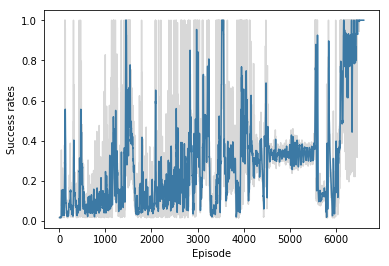

In [104]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

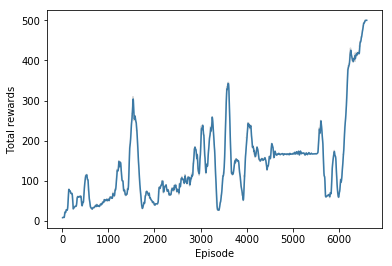

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

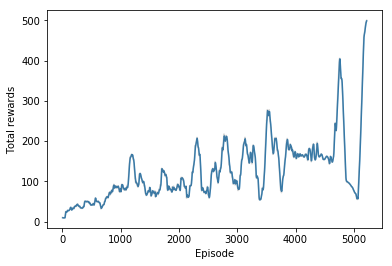

In [82]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

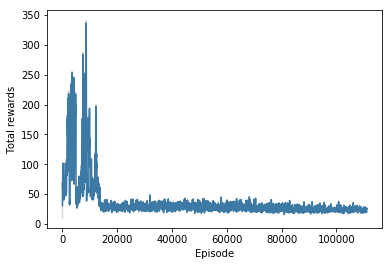

In [67]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

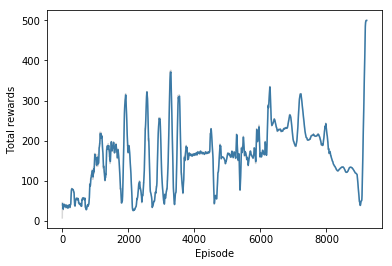

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

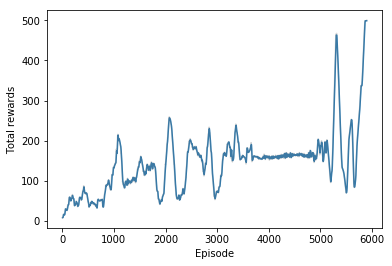

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

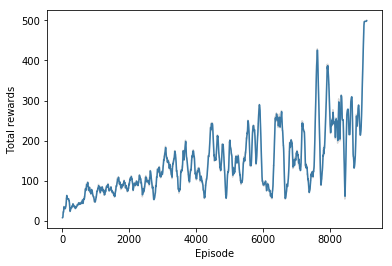

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

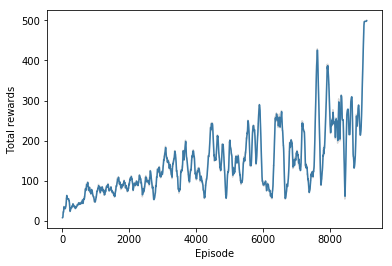

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

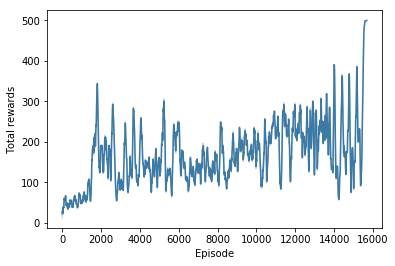

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

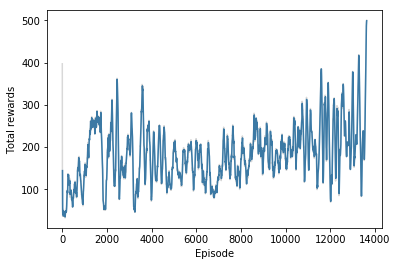

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

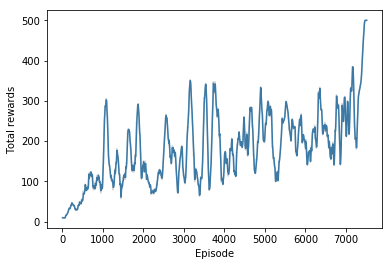

Text(0,0.5,'G losses')

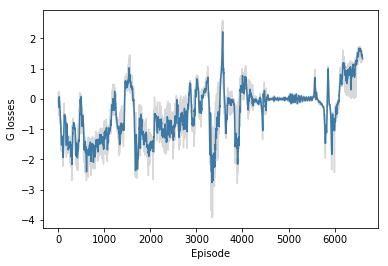

In [105]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

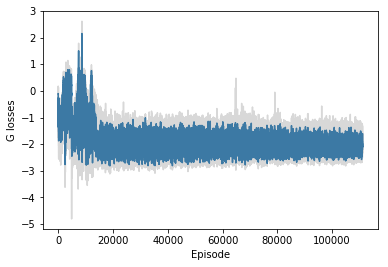

In [68]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

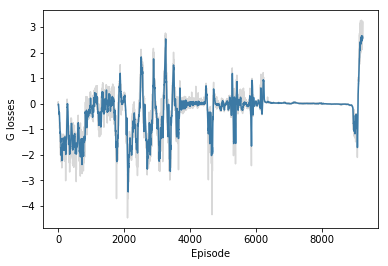

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

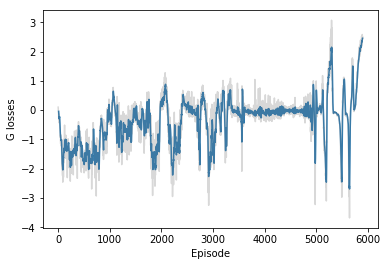

In [29]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

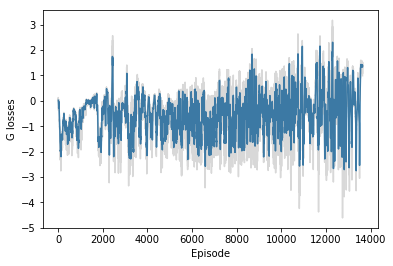

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

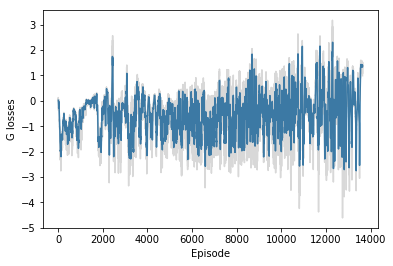

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

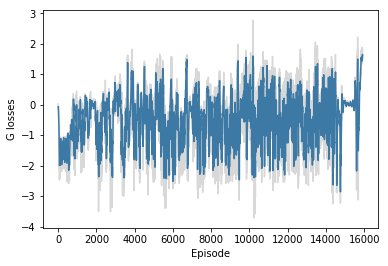
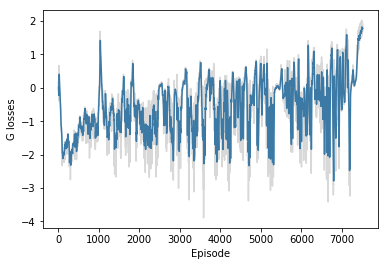

Text(0,0.5,'D losses')

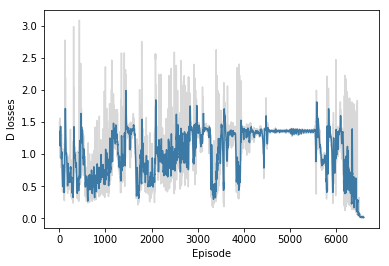

In [106]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

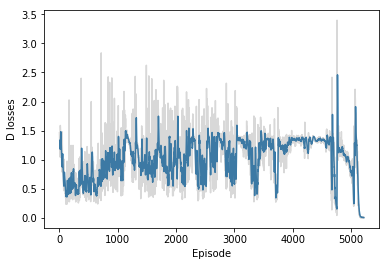

In [83]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

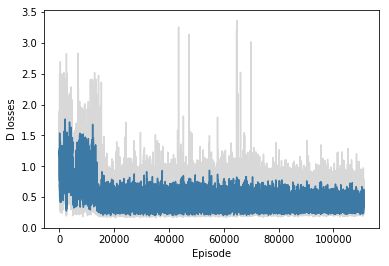

In [69]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

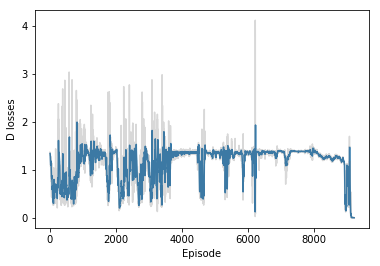

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

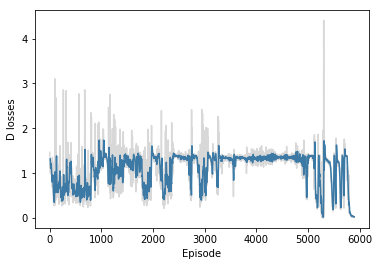

In [30]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

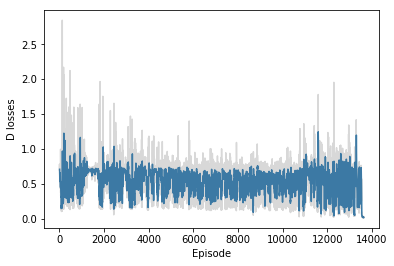

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

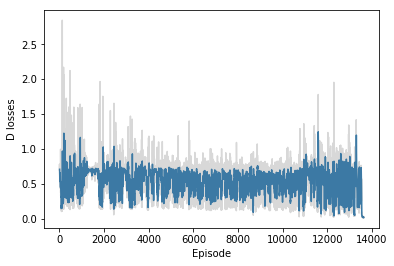

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

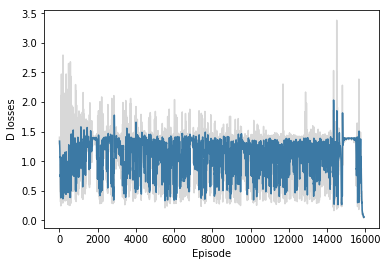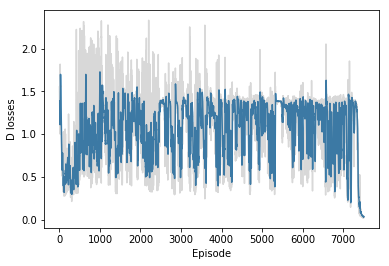

Text(0,0.5,'D losses R')

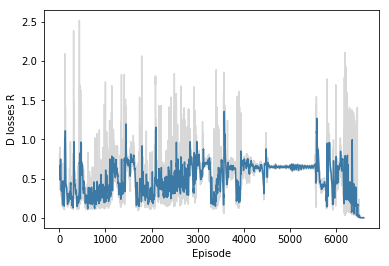

In [107]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

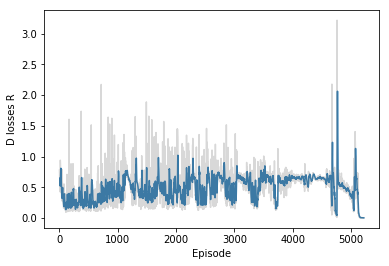

In [84]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

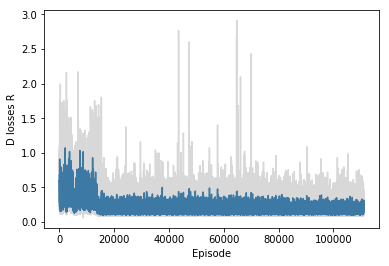

In [70]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

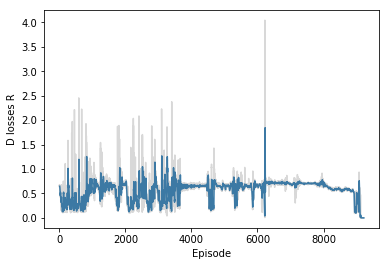

In [55]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

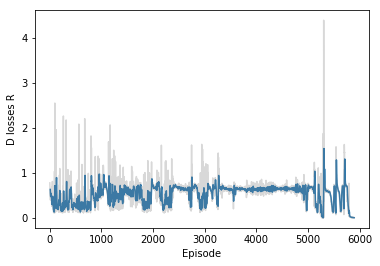

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

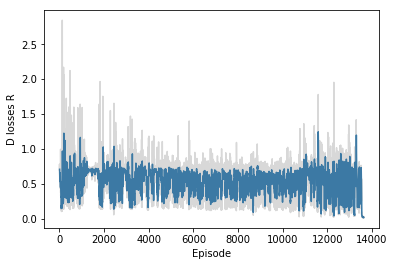

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

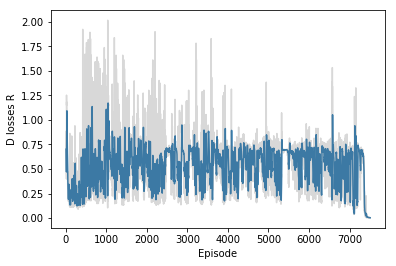

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

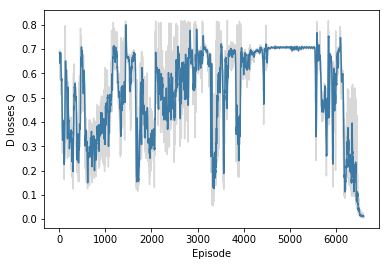

In [108]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

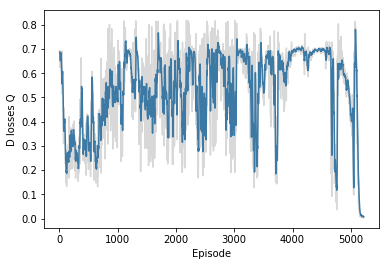

In [85]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

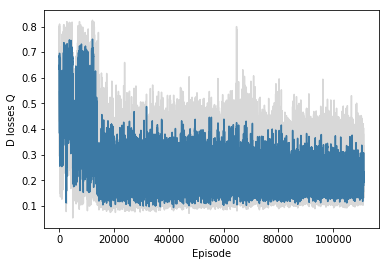

In [71]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

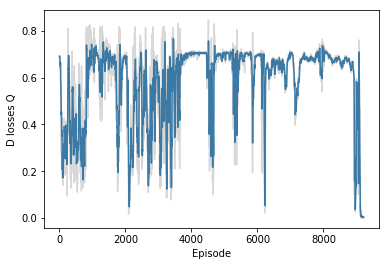

In [56]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

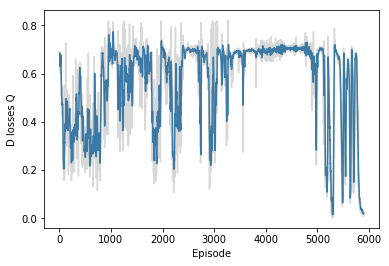

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

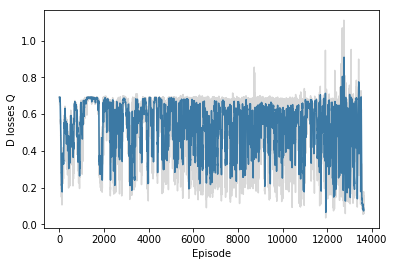

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

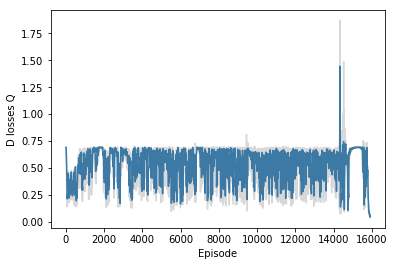

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

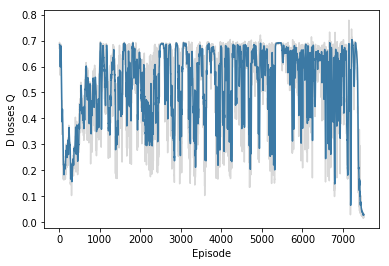

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.